# S1 - Temporal transferbility

Transfer the trained model to predict data from Nord Hessen in 2010, 2011, and 2012

### 1.0 Loading libraries and setting path

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

In [2]:
import tensorflow as tf
import tensorflow_probability as tfp
import seaborn as sns

from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import InputLayer, Input, Conv2D, MaxPool2D, BatchNormalization, Flatten, Dense, Dropout, MaxPooling2D
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.losses import CategoricalCrossentropy

from sklearn.preprocessing import MinMaxScaler, StandardScaler

from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

from sklearn.metrics import classification_report

from sklearn.ensemble import RandomForestClassifier
import skopt

from tensorflow.keras.models import load_model
import joblib

2023-05-15 14:09:25.149277: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-15 14:09:26.007416: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/cuda-11.2/lib64:/usr/local/cuda-11.2/extras/CUPTI/lib64
2023-05-15 14:09:26.007494: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/cuda-11.2/lib64:/usr/local/cuda-11.2/extras/CUPTI/

In [3]:
os.chdir('/home/pc4dl/SYM2')

In [4]:
print("Tensorflow Version: ", tf. __version__) 
print("Tensorflow Probability Version: ", tfp.__version__)

Tensorflow Version:  2.11.0
Tensorflow Probability Version:  0.18.0


### 2.0 Define functions for reading, prepare and visualising data

In [5]:
def preapre_df(df):
    """
    This function read the dataframe and filter out the unwanted years and generate seperate
    dataframes for a) only with SR bands, b) only with VIs, and c) both with SR bands & VIs.
    """
    year_list = [*range(2010, 2019, 1)]
    df_years = df[df['year'].isin(year_list)]
    df_dropna = df_years.dropna()
    
    df_sr = df_dropna.iloc[:, [0, 47, 5,  
                               7, 8, 9, 10, 11, 12, 
                               17, 18, 19, 20, 21, 22, 
                               27, 28, 29, 30, 31, 32, 
                               37, 38, 39, 40, 41, 42]]
    
    df_vi = df_dropna.iloc[:, [0, 47, 5,  
                               13, 14, 15, 16, 
                               23, 24, 25, 26, 
                               33, 34, 35, 36, 
                               43, 44, 45, 46]]
    df_sr_vi = df_dropna.iloc[:, [0, 47, 5,  
                               7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 
                               17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 
                               27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 
                               37, 38, 39, 40, 41, 42, 43, 44, 45, 46]]
    
    return df_sr, df_vi, df_sr_vi


def s1_df(df):
    
    df2 = df.copy()
    test_years = [2010, 2011, 2012]
    
    df_y = df2[df2['year'].isin(test_years)]
    
    return df_y

def norm(df):
    MIN = df.min(1)
    MAX = df.max(1)
    return df.sub(MIN, 0).div(MAX-MIN, 0)

def s_df_np(df):
    """
    This function convert dataframes to numpy arrays.
    """
    
    df_X = df.iloc[:, 3:43] # norm(df.iloc[:, 3:43])
    np_X = df_X.to_numpy()
    
    np_X = np.transpose(np_X.reshape(np_X.shape[0], 4, 10), (0, 2, 1))
    np_X = np.expand_dims(np_X, axis=3)
    
    np_Y = df.iloc[:, 2].to_numpy()
    
    return df_X, np_X, np_Y

def cl_levels(npa):
    """
    This function recreate generated label numpy arrays according to two different class levels.
    CL1 is for 3 classes - 0: Other, 1: Maize, 2: Grasslands
    CL2 is for 5 classes - 0: Other, 1: Maize, 2: Grasslands, 3: Summer crops, 4: Winter Crops
    """
    cl2_np = npa.copy()
    cl1_np = npa.copy()
    
    cl2_np[cl2_np == 'OT'] = 0
    cl2_np[cl2_np == 'MZ'] = 1
    cl2_np[cl2_np == 'PG'] = 2
    cl2_np[cl2_np == 'SC'] = 3
    cl2_np[cl2_np == 'WC'] = 4
    cl2_np[cl2_np == 'TG'] = 2
    
    cl1_np[cl1_np == 'OT'] = 0
    cl1_np[cl1_np == 'MZ'] = 1
    cl1_np[cl1_np == 'PG'] = 2
    cl1_np[cl1_np == 'SC'] = 0
    cl1_np[cl1_np == 'WC'] = 0
    cl1_np[cl1_np == 'TG'] = 2
    
    cl1_np = np.asarray(cl1_np).astype('float32')
    cl2_np = np.asarray(cl2_np).astype('float32')
    
    return cl1_np, cl2_np

def cl_print(cl_np):
    """
    This function prints the frequency of each class.
    """
    tst_u_cl, tst_u_frq = np.unique(cl_np, return_counts=True)
    tst_u_cl_frq = zip(tst_u_cl, tst_u_frq)
    for elem in tst_u_cl_frq:
        print(elem[0], ' Occurs :', elem[1], ' times')
    print('########################')

In [6]:
cl1_names={ 0: 'Other', 1: 'Maize', 2: 'Grasslands'}
cl2_names={ 0: 'Other', 1: 'Maize', 2: 'Grasslands', 3: 'Summer Crops', 4: 'Winter Crops'}

In [7]:
def visualize_batch(data_X, data_Y1, data_Y2, cls1, cls2, tv=None):
    rnd = random.sample(range(10, data_X.shape[0]), 25)
    # initialize a figure
    fig = plt.figure(figsize=(10, 10))
    fig.suptitle(tv, fontsize=16)
    # loop over the batch size
    for i in range(25):
        # create a subplot
        ax = plt.subplot(5, 5, i + 1)
        mat = data_X[rnd[i]]
        # grab the label id and get the label from the classes list
        idx_1 = data_Y1[rnd[i]]
        idx_2 = data_Y2[rnd[i]]
        label_1 = cls1[idx_1]
        label_2 = cls2[idx_2]
        label = "CL1: " + label_1 + "\nCL2: " + label_2
        # show the image along with the label
        plt.imshow(mat, cmap='viridis')
        plt.title(label)
        plt.axis("off")
        # show the plot
    plt.tight_layout()
    plt.show()

## 3.0 Read data

In [8]:
# Read CSVs

nh_l578 = pd.read_csv(r'./OriginalData_NH/L578_extract/NH_L578_all_norm.csv')
we_l578 = pd.read_csv(r'./OriginalData_WE/L578_extract/WE_L578_all_norm.csv')

year_list = [*range(2010, 2019, 1)]

### 3.1 Prepare data

In [9]:

# Prepare dataframes and generate seperate dataframes

nh_l578_sr, nh_l578_vi, nh_l578_sr_vi = preapre_df(nh_l578)
we_l578_sr, we_l578_vi, we_l578_sr_vi = preapre_df(we_l578)

# 2.0 Data for testing in Scenario 1 (Model trained in Location A + Time T1 --> Test in Location A + Time T2)

s1_nh_test_df = s1_df(nh_l578_sr_vi)
s1_we_test_df = s1_df(we_l578_sr_vi)


# Create necessary DF and NPs
s1_nh_test_X_df, s1_nh_test_X_np, s1_nh_test_Y_np = s_df_np(s1_nh_test_df)
s1_we_test_X_df, s1_we_test_X_np, s1_we_test_Y_np = s_df_np(s1_we_test_df)

# Create two levels of Y
s1_nh_test_Y_np_cl1, s1_nh_test_Y_np_cl2 = cl_levels(s1_nh_test_Y_np)
s1_we_test_Y_np_cl1, s1_we_test_Y_np_cl2 = cl_levels(s1_we_test_Y_np)

cl_print(s1_nh_test_Y_np_cl1)
cl_print(s1_nh_test_Y_np_cl2)

cl_print(s1_we_test_Y_np_cl1)
cl_print(s1_we_test_Y_np_cl2)

0.0  Occurs : 139406  times
1.0  Occurs : 15786  times
2.0  Occurs : 89479  times
########################
0.0  Occurs : 9099  times
1.0  Occurs : 15786  times
2.0  Occurs : 89479  times
3.0  Occurs : 20632  times
4.0  Occurs : 109675  times
########################
0.0  Occurs : 163086  times
1.0  Occurs : 177142  times
2.0  Occurs : 258697  times
########################
0.0  Occurs : 13493  times
1.0  Occurs : 177142  times
2.0  Occurs : 258697  times
3.0  Occurs : 37947  times
4.0  Occurs : 111646  times
########################


In [10]:
# shape of the training and validation set
print('Shape of the S1 testing dataset \n Train X: ' + str(s1_we_test_X_np.shape))
print('Shape of the S1 testing dataset \n Train Y (CL1): ' + str(s1_we_test_Y_np_cl1.shape))
print('Shape of the S1 testing dataset \n Train Y (CL2): ' + str(s1_we_test_Y_np_cl2.shape))

Shape of the S1 testing dataset 
 Train X: (598925, 10, 4, 1)
Shape of the S1 testing dataset 
 Train Y (CL1): (598925,)
Shape of the S1 testing dataset 
 Train Y (CL2): (598925,)


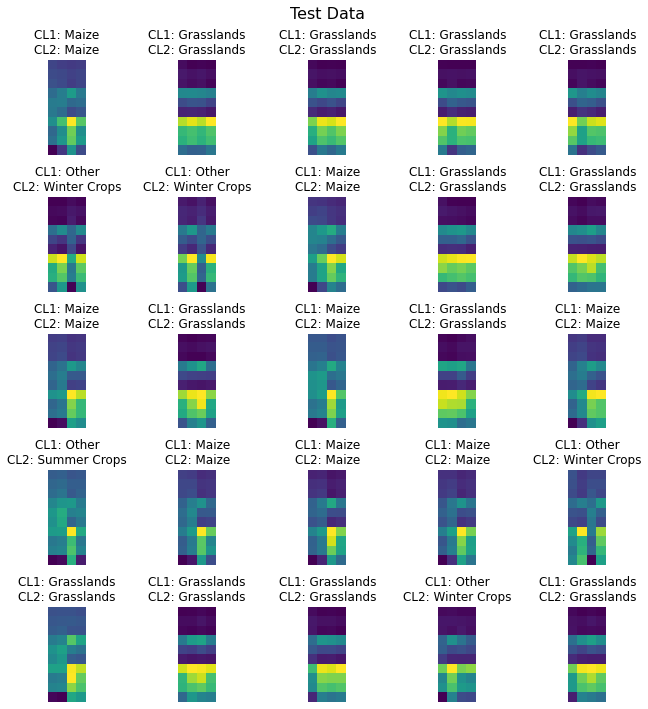

In [11]:
visualize_batch(s1_we_test_X_np, s1_we_test_Y_np_cl1, s1_we_test_Y_np_cl2, cl1_names, cl2_names, "Test Data")

## 3.2 DI and AOA

In [12]:
from sklearn.neighbors import BallTree
from scipy.spatial.distance import pdist, squareform
def aoa(new_data, 
        training_data, 
        model=None, 
        thres=0.95,
        fold_indices=None,
        distance_metric='euclidean'
       ):
    """
    Area of Applicability (AOA) measure for spatial prediction models from
    Meyer and Pebesma (2020). The AOA defines the area for which, on average, 
    the cross-validation error of the model applies, which is crucial for 
    cases where spatial predictions are used to inform decision-making.
    
    Parameters
    ----------
    new_data : GeoDataFrame
        A GeoDataFrame containing unseen data to measure AOA for.
    training_data : GeoDataFrame
        A GeoDataFrame containing the features used for model training.
    thres : default=0.95
        Threshold used to identify predictive area of applicability.
    fold_indices : iterable, default=None
        iterable consisting of training indices that identify instances in the
        folds.
    distance_metric : string, default='euclidean'
        Distance metric to calculate distances between new_data and training_data.
        Defaults to euclidean for projected CRS, otherwise haversine for unprojected.
    Returns
    -------
    DIs : array
        Array of disimimilarity scores between training_data for new_data points.
    masked_result : array
        Binary mask that occludes points outside predictive area of applicability.
    """
    
    
    if len(training_data) <= 1:
        raise Exception('At least two training instances need to be specified.')
                    
    # Scale data 
    training_data = (training_data - np.mean(training_data)) / np.std(training_data)
    new_data = (new_data - np.mean(new_data)) / np.std(new_data)

    # Calculate nearest training instance to test data, return Euclidean distances
    tree = BallTree(training_data, metric=distance_metric) 
    mindist, _ = tree.query(new_data, k=1, return_distance=True)

    # Build matrix of pairwise distances 
    paired_distances = pdist(training_data)
    train_dist = squareform(paired_distances)
    np.fill_diagonal(train_dist, np.nan)
    
    # Remove data points that are within the same fold
    if fold_indices:            
        # Get number of training instances in each fold
        instances_in_folds = [len(fold) for fold in fold_indices]
        instance_fold_id = np.repeat(np.arange(0, len(fold_indices)), instances_in_folds)

        # Create mapping between training instance and fold ID
        fold_indices = np.concatenate(fold_indices)
        folds = np.vstack((fold_indices, instance_fold_id)).T

        # Mask training points in same fold for DI measure calculation
        for i, row in enumerate(train_dist):
            mask = folds[:,0] == folds[:,0][i]
            train_dist[i, mask] = np.nan

    # Scale distance to nearest training point by average distance across training data
    train_dist_mean = np.nanmean(train_dist, axis=1)
    train_dist_avgmean = np.mean(train_dist_mean)
    mindist /= train_dist_avgmean    

    # Define threshold for AOA
    train_dist_min = np.nanmin(train_dist, axis=1)
    aoa_train_stats = np.quantile(train_dist_min / train_dist_avgmean, 
                                    q = np.array([0.25, 0.5, 0.75, 0.9, 0.95, 0.99, 1]))
    thres = np.quantile(train_dist_min / train_dist_avgmean, q = thres)
    
    # We choose the AOA as the area where the DI does not exceed the threshold
    DIs = mindist.reshape(-1)
    masked_result = np.repeat(1, len(mindist))
    masked_result[DIs > thres] = 0

    return DIs, masked_result, thres

In [13]:
org_train_data = pd.read_csv(r'./OriginalData_WE/L578_extract/s_we_train_df.csv')
org_train_data = org_train_data.iloc[: , 1:]
# org_train_data

In [14]:
DI, Masked, thres = aoa(new_data=s1_we_test_X_df, 
        training_data=org_train_data, 
        model=None, 
        thres=0.95,
        fold_indices=None,
        distance_metric='euclidean'
       )

In [15]:
thres

0.32091374832106373

In [16]:
unique, counts = np.unique(Masked, return_counts=True)
print(np.asarray((unique, counts)).T)

[[     0  70369]
 [     1 528556]]


## 4.0 Load Models

In [17]:
# CNN
deterministic_model_cl1 = load_model('./Out/CNN_Models/dcnn_model_we_cl1_trained.hdf5', compile=False)
deterministic_model_cl2 = load_model('./Out/CNN_Models/dcnn_model_we_cl2_trained.hdf5', compile=False)

# RF
rf_model_cl1 = joblib.load("./Out/RF_Models/rf_model_we_cl1_trained.joblib")
rf_model_cl2 = joblib.load("./Out/RF_Models/rf_model_we_cl2_trained.joblib")

2023-05-15 15:01:23.230663: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-15 15:01:23.231066: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-15 15:01:23.241595: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-15 15:01:23.241989: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-15 15:01:23.242358: I tensorflow/compiler/xla/stream_executo

## 5.0 Test Models

### 5.1 CNN model test

In [18]:
# Check traget system accuracy

cnn_model_s1_we_test_cl1_y_pred = deterministic_model_cl1.predict(s1_we_test_X_np)
cnn_model_s1_we_test_cl2_y_pred = deterministic_model_cl2.predict(s1_we_test_X_np)
# Convert predictions classes to one hot vectors
cnn_model_s1_we_test_cl1_y_pred_classes = np.argmax(cnn_model_s1_we_test_cl1_y_pred, axis = 1) 
cnn_model_s1_we_test_cl2_y_pred_classes = np.argmax(cnn_model_s1_we_test_cl2_y_pred, axis = 1)
# Convert test data to one hot vectors
cnn_model_s1_we_test_cl1_y_true = s1_we_test_Y_np_cl1
cnn_model_s1_we_test_cl2_y_true = s1_we_test_Y_np_cl2

# CM
cnn_model_s1_we_test_cl1_cm = confusion_matrix(cnn_model_s1_we_test_cl1_y_true, cnn_model_s1_we_test_cl1_y_pred_classes)
cnn_model_s1_we_test_cl2_cm = confusion_matrix(cnn_model_s1_we_test_cl2_y_true, cnn_model_s1_we_test_cl2_y_pred_classes)

# Accuracy
cnn_model_s1_we_test_cl1_acc = accuracy_score(y_true=cnn_model_s1_we_test_cl1_y_true, y_pred=cnn_model_s1_we_test_cl1_y_pred_classes, normalize=True)
cnn_model_s1_we_test_cl2_acc = accuracy_score(y_true=cnn_model_s1_we_test_cl2_y_true, y_pred=cnn_model_s1_we_test_cl2_y_pred_classes, normalize=True)

# Macro F1
cnn_model_s1_we_test_cl1_macroF1 = f1_score(y_true=cnn_model_s1_we_test_cl1_y_true, y_pred=cnn_model_s1_we_test_cl1_y_pred_classes, average='macro')
cnn_model_s1_we_test_cl2_macroF1 = f1_score(y_true=cnn_model_s1_we_test_cl2_y_true, y_pred=cnn_model_s1_we_test_cl2_y_pred_classes, average='macro')

print("=================================\n")
print('S1 CNN WE Model CL1 Test')
print(cnn_model_s1_we_test_cl1_cm)
print("Test accuracy for S1 CNN WE model for CL1: " + str(round(cnn_model_s1_we_test_cl1_acc, 3)))
print("Test MacroF1 for S1 CNN WE model for CL1: " + str(round(cnn_model_s1_we_test_cl1_macroF1, 3)))
print("=================================\n")
print('S1 CNN WE Model CL2 Test')
print(cnn_model_s1_we_test_cl2_cm)
print("Test accuracy for S1 CNN WE model for CL2: " + str(round(cnn_model_s1_we_test_cl2_acc, 3)))
print("Test MacroF1 for S1 CNN WE model for CL2: " + str(round(cnn_model_s1_we_test_cl2_macroF1, 3)))

2023-05-15 15:01:28.762083: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100


18717/18717 [==============================] - 22s 1ms/step

S1 CNN WE Model CL1 Test
[[153795   4836   4455]
 [ 40413 134168   2561]
 [ 18401   1070 239226]]
Test accuracy for S1 CNN WE model for CL1: 0.88
Test MacroF1 for S1 CNN WE model for CL1: 0.871

S1 CNN WE Model CL2 Test
[[  4598   2595    719   4140   1441]
 [  9155 149887   1871  15572    657]
 [ 33716   1905 220806   1732    538]
 [  4876   2971    422  28828    850]
 [  9830   1122   2551   7091  91052]]
Test accuracy for S1 CNN WE model for CL2: 0.827
Test MacroF1 for S1 CNN WE model for CL2: 0.683


In [19]:
cnn_model_s1_we_test_cl1_clsF1 = f1_score(y_true=cnn_model_s1_we_test_cl1_y_true, y_pred=cnn_model_s1_we_test_cl1_y_pred_classes, average=None)

cnn_s1_cl1_f1 = [list(cl1_names.values()), cnn_model_s1_we_test_cl1_clsF1.tolist()]
cnn_s1_cl1_f1_df = pd.DataFrame(cnn_s1_cl1_f1)
cnn_s1_cl1_f1_df = cnn_s1_cl1_f1_df.transpose()
 
# specifying column names
cnn_s1_cl1_f1_df.columns = ['Class', 'F1']

print("=================================\n")
print('S1 CNN WE Model CL1 Test')
cnn_s1_cl1_f1_df



S1 CNN WE Model CL1 Test


,Class,F1
0,Other,0.818723
1,Maize,0.845909
2,Grasslands,0.947544


In [20]:
cnn_model_s1_we_test_cl2_clsF1 = f1_score(y_true=cnn_model_s1_we_test_cl2_y_true, y_pred=cnn_model_s1_we_test_cl2_y_pred_classes, average=None)

cnn_s1_cl2_f1 = [list(cl2_names.values()), cnn_model_s1_we_test_cl2_clsF1.tolist()]
cnn_s1_cl2_f1_df = pd.DataFrame(cnn_s1_cl2_f1)
cnn_s1_cl2_f1_df = cnn_s1_cl2_f1_df.transpose()
 
# specifying column names
cnn_s1_cl2_f1_df.columns = ['Class', 'F1']

print("=================================\n")
print('S1 CNN WE Model CL2 Test')
cnn_s1_cl2_f1_df



S1 CNN WE Model CL2 Test


,Class,F1
0,Other,0.121531
1,Maize,0.893189
2,Grasslands,0.910416
3,Summer Crops,0.604931
4,Winter Crops,0.883211


### 5.2 RF Model Test

In [21]:
# Check target system accuracy

rf_model_s1_we_test_cl1_y_pred = rf_model_cl1.predict(s1_we_test_X_df)
rf_model_s1_we_test_cl2_y_pred = rf_model_cl2.predict(s1_we_test_X_df)

# Convert predictions classes to one hot vectors 9
rf_model_s1_we_test_cl1_y_pred_classes = rf_model_s1_we_test_cl1_y_pred # np.argmax(rf_model_s1_we_test_cl1_y_pred, axis = 1) 
rf_model_s1_we_test_cl2_y_pred_classes = rf_model_s1_we_test_cl2_y_pred # np.argmax(rf_model_s1_we_test_cl2_y_pred, axis = 1)
# Convert test data to one hot vectors
rf_model_s1_we_test_cl1_y_true = s1_we_test_Y_np_cl1
rf_model_s1_we_test_cl2_y_true = s1_we_test_Y_np_cl2

# CM
rf_model_s1_we_test_cl1_cm = confusion_matrix(rf_model_s1_we_test_cl1_y_true, rf_model_s1_we_test_cl1_y_pred_classes)
rf_model_s1_we_test_cl2_cm = confusion_matrix(rf_model_s1_we_test_cl2_y_true, rf_model_s1_we_test_cl2_y_pred_classes)

# Accuracy
rf_model_s1_we_test_cl1_acc = accuracy_score(y_true=rf_model_s1_we_test_cl1_y_true, y_pred=rf_model_s1_we_test_cl1_y_pred_classes, normalize=True)
rf_model_s1_we_test_cl2_acc = accuracy_score(y_true=rf_model_s1_we_test_cl2_y_true, y_pred=rf_model_s1_we_test_cl2_y_pred_classes, normalize=True)

# Macro F1
rf_model_s1_we_test_cl1_macroF1 = f1_score(y_true=rf_model_s1_we_test_cl1_y_true, y_pred=rf_model_s1_we_test_cl1_y_pred_classes, average='macro')
rf_model_s1_we_test_cl2_macroF1 = f1_score(y_true=rf_model_s1_we_test_cl2_y_true, y_pred=rf_model_s1_we_test_cl2_y_pred_classes, average='macro')

print("=================================\n")
print('S1 RF WE Model CL1 Test')
print(rf_model_s1_we_test_cl1_cm)
print("Test accuracy for S1 RF WE model for CL1: " + str(round(rf_model_s1_we_test_cl1_acc, 3)))
print("Test MacroF1 for S1 RF WE model for CL1: " + str(round(rf_model_s1_we_test_cl1_macroF1, 3)))
print("=================================\n")
print('S1 RF WE Model CL2 Test')
print(rf_model_s1_we_test_cl2_cm)
print("Test accuracy for S1 RF WE model for CL2: " + str(round(rf_model_s1_we_test_cl2_acc, 3)))
print("Test MacroF1 for S1 RF WE model for CL2: " + str(round(rf_model_s1_we_test_cl2_macroF1, 3)))

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.4s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    2.3s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    5.4s
[Parallel(n_jobs=12)]: Done 600 out of 600 | elapsed:    7.5s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.5s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    2.8s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    6.6s
[Parallel(n_jobs=12)]: Done 600 out of 600 | elapsed:    9.2s finished



S1 RF WE Model CL1 Test
[[155600   4280   3206]
 [ 48230 126397   2515]
 [ 29340   1450 227907]]
Test accuracy for S1 RF WE model for CL1: 0.851
Test MacroF1 for S1 RF WE model for CL1: 0.843

S1 RF WE Model CL2 Test
[[  4138   2442   1173   4217   1523]
 [  9690 137442   2960  26521    529]
 [ 18068   1923 235024   2360   1322]
 [  4556   2116    584  29560   1131]
 [  5843    814   4127   5925  94937]]
Test accuracy for S1 RF WE model for CL2: 0.837
Test MacroF1 for S1 RF WE model for CL2: 0.678


In [22]:
rf_model_s1_we_test_cl1_clsF1 = f1_score(y_true=rf_model_s1_we_test_cl1_y_true, y_pred=rf_model_s1_we_test_cl1_y_pred_classes, average=None)

rf_s1_cl1_f1 = [list(cl1_names.values()), rf_model_s1_we_test_cl1_clsF1.tolist()]
rf_s1_cl1_f1_df = pd.DataFrame(rf_s1_cl1_f1)
rf_s1_cl1_f1_df = rf_s1_cl1_f1_df.transpose()
 
# specifying column names
rf_s1_cl1_f1_df.columns = ['Class', 'F1']

print("=================================\n")
print('S1 RF WE Model CL1 Test')
rf_s1_cl1_f1_df



S1 RF WE Model CL1 Test


,Class,F1
0,Other,0.785351
1,Maize,0.817392
2,Grasslands,0.92584


In [23]:
rf_model_s1_we_test_cl2_clsF1 = f1_score(y_true=rf_model_s1_we_test_cl2_y_true, y_pred=rf_model_s1_we_test_cl2_y_pred_classes, average=None)

rf_s1_cl2_f1 = [list(cl2_names.values()), rf_model_s1_we_test_cl2_clsF1.tolist()]
rf_s1_cl2_f1_df = pd.DataFrame(rf_s1_cl2_f1)
rf_s1_cl2_f1_df = rf_s1_cl2_f1_df.transpose()
 
# specifying column names
rf_s1_cl2_f1_df.columns = ['Class', 'F1']

print("=================================\n")
print('S1 RF WE Model CL2 Test')
rf_s1_cl2_f1_df



S1 RF WE Model CL2 Test


,Class,F1
0,Other,0.148347
1,Maize,0.853998
2,Grasslands,0.935298
3,Summer Crops,0.554961
4,Winter Crops,0.899502


## 6.0 Get model outputs

In [24]:
s1_base = s1_we_test_df.iloc[:, [0, 1, 2]]

### 6.1 CNN

In [25]:
s1_cnn_out_df = s1_base.copy()

s1_cnn_out_df['cl1_true'] = (np.array(cnn_model_s1_we_test_cl1_y_true, int)).tolist()

s1_cnn_out_df['cl1_pred'] = cnn_model_s1_we_test_cl1_y_pred_classes.tolist()

s1_cnn_out_df['cl2_true'] = (np.array(cnn_model_s1_we_test_cl2_y_true, int)).tolist()

s1_cnn_out_df['cl2_pred'] = cnn_model_s1_we_test_cl2_y_pred_classes.tolist()

s1_cnn_out_df['DI'] = DI.tolist()

s1_cnn_out_df['AOA'] = Masked.tolist()

s1_cnn_out_df

,p_id,year,CAT,cl1_true,cl1_pred,cl2_true,cl2_pred,DI,AOA
0,2010_000001,2010,PG,2,2,2,2,0.105736,1
1,2010_000002,2010,TG,2,0,2,0,0.245224,1
2,2010_000003,2010,PG,2,2,2,2,0.174706,1
3,2010_000004,2010,PG,2,2,2,2,0.152237,1
4,2010_000005,2010,MZ,1,0,1,3,0.260542,1
...,...,...,...,...,...,...,...,...,...
599435,2012_275759,2012,MZ,1,0,1,1,0.239118,1
599436,2012_275762,2012,WC,0,2,4,2,0.581358,0
599437,2012_275767,2012,PG,2,2,2,2,0.200748,1
599438,2012_275770,2012,WC,0,0,4,4,0.460252,0


In [26]:
s1_cnn_out_df.to_csv('./Out/CNN_Models/s1_WE_cnn_out.csv')

### 6.2 RF

In [27]:
s1_rf_out_df = s1_base.copy()

s1_rf_out_df['cl1_true'] = (np.array(rf_model_s1_we_test_cl1_y_true, int)).tolist()

s1_rf_out_df['cl1_pred'] = rf_model_s1_we_test_cl1_y_pred_classes.tolist()

s1_rf_out_df['cl2_true'] = (np.array(rf_model_s1_we_test_cl2_y_true, int)).tolist()

s1_rf_out_df['cl2_pred'] = rf_model_s1_we_test_cl2_y_pred_classes.tolist()

s1_rf_out_df['DI'] = DI.tolist()

s1_rf_out_df['AOA'] = Masked.tolist()

s1_rf_out_df

,p_id,year,CAT,cl1_true,cl1_pred,cl2_true,cl2_pred,DI,AOA
0,2010_000001,2010,PG,2,2.0,2,2.0,0.105736,1
1,2010_000002,2010,TG,2,0.0,2,2.0,0.245224,1
2,2010_000003,2010,PG,2,2.0,2,2.0,0.174706,1
3,2010_000004,2010,PG,2,2.0,2,2.0,0.152237,1
4,2010_000005,2010,MZ,1,0.0,1,3.0,0.260542,1
...,...,...,...,...,...,...,...,...,...
599435,2012_275759,2012,MZ,1,0.0,1,3.0,0.239118,1
599436,2012_275762,2012,WC,0,0.0,4,2.0,0.581358,0
599437,2012_275767,2012,PG,2,2.0,2,2.0,0.200748,1
599438,2012_275770,2012,WC,0,0.0,4,4.0,0.460252,0


In [28]:
s1_rf_out_df.to_csv('./Out/RF_Models/s1_WE_rf_out.csv')